In [1]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import scipy.io as sio
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import pickle
import os


monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

# root_dir = '/Users/f005d7d/Documents/Attn_MdPRL/what-where-task/'
root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'

bhv_path = os.path.join(root_dir, 'Behavior/')
processed_path = os.path.join(root_dir, 'processed/')
neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')

binsize = 0.01
gauss_window = 0.5/binsize
gauss_SD = 0.05/binsize
# window_start = int(1/binsize)

all_sess_regression_info = {
    'aligned_event': [],
    'monkey_name': [],
    'area_name': [],
    'sess_date': [],
    'betas': [],
    'exp_vars': []
}

# 12 regressors, separate by blocks
regressor_names = ['type', 'block', 
                'S_curr', 'C_what_curr', 'C_where_curr', 'R_curr',
                'C_what_prev', 'C_where_prev', 'R_prev',
                'RXC_where', 'RXC_what',
                'SXC_what', 'RXS', 'RXSXC_what']

regressor_expr = ['C(block_type, Sum)/C(block_id, Sum)', 
                '(C(block_type, Sum)/C(block_id, Sum)):C_what_curr:C_where_curr', 
                '(C(block_type, Sum)/C(block_id, Sum)):C_what_curr', 
                'C(block_type, Sum)*C_where_curr', 'C(block_type, Sum)*R_curr',
                '(C(block_type, Sum)/C(block_id, Sum)):C_what_prev', 
                'C(block_type, Sum)*C_where_prev', 'C(block_type, Sum)*R_prev',
                'C(block_type, Sum)*(R_prev:C_where_prev)', 
                '(C(block_type, Sum)/C(block_id, Sum)):R_prev:C_what_prev',
                'C(block_type, Sum)*(C_what_curr:C_where_curr:C_what_prev)',
                '(C(block_type, Sum)/C(block_id, Sum)):R_prev:C_what_curr:C_where_curr',
                'C(block_type, Sum)*(R_prev:C_what_curr:C_where_curr:C_what_prev)']

var_names_in_table = ['C_what_curr', 'C_where_curr', 'R_curr', 'block_type', 'block_id', 
                    'C_what_prev', 'C_where_prev', 'R_prev']

formula = 'fr~'+'+'.join(regressor_expr)

In [32]:
for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(f'RastVect-{monkey_name}(\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

            neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)

            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            task_info = task_info[:,[0,1,2,9,7]].astype(float) #only keep chosen image, chosen loc, reward, block type, block id

            trial_mask = task_info[:,4]<=24
            task_info = task_info[trial_mask]
            neural_data = neural_data[trial_mask]
            # neural_data = neural_data[:,:,window_start:]
            num_trials, num_units, num_timesteps = neural_data.shape

            print("aligned to: " + aligned_event + ", monkey: " + monkey_name + ", session: " + sess_date)


            task_info[:,:3] = task_info[:,:3]*2-1
            task_info[:,3] = task_info[:,3]*2-3
            task_info[:,4] = task_info[:,4]%12

            # make the time-lagged part of the design
            task_info_prev = np.concatenate([np.array([[0,0,0]]), task_info[:-1,:3]], axis=0)
            
            # put together design matrix
            # C_what_curr, C_where_curr, R_curr, block_id, block_type
            # C_what_prev, C_where_prev, R_curr
            X = np.concatenate([task_info, task_info_prev], axis=1)

            num_betas = 158
            num_exp_vars = 27

            all_units_beta = np.ones((num_timesteps, num_units, num_betas))*np.nan;
            all_units_exp_var = np.ones((num_timesteps, num_units, num_exp_vars))*np.nan;

            for unit_idx in tqdm(range(6, num_units)):
                def run_linreg_anova(time_idx):
                    curr_unit_time_fr = neural_data[:, unit_idx, time_idx]

                    tbl = pd.DataFrame(np.concatenate([curr_unit_time_fr[:,None], X], axis=1),
                                    columns=['fr']+var_names_in_table)
                    mdl = smf.ols(formula, tbl).fit()
                    anova_mdl = sm.stats.anova_lm(mdl, typ=3)

                    return [mdl.params, anova_mdl.sum_sq[:-1]/anova_mdl.sum_sq.sum()]
                
                linreg_anova_results = Parallel(n_jobs=4)(delayed(run_linreg_anova)(time_idx) for time_idx in range(num_timesteps))
                
                all_units_beta[:, unit_idx, :] = np.stack([curr_time_results[0] for curr_time_results in linreg_anova_results])
                all_units_exp_var[:, unit_idx, :] = np.stack([curr_time_results[1] for curr_time_results in linreg_anova_results])


            all_sess_regression_info['monkey_name'].append(monkey_name)
            all_sess_regression_info['area_name'].append(curr_sess_bhv['ArrayArea'])
            all_sess_regression_info['sess_date'].append(sess_date)
            all_sess_regression_info['betas'].append(all_units_beta)
            all_sess_regression_info['exp_vars'].append(all_units_exp_var)

            with open(os.path.join(processed_path, 'all_sess_regression_info.pkl')) as f:
                pickle.dump(all_sess_regression_info, f)


In [30]:
re.search(re.compile(f'RastVect-{monkey_name}(\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

'20160122'

In [16]:
curr_sess_bhv['ArrayArea'].shape

(576, 2)

In [20]:
anova_mdl

,sum_sq,df,F,PR(>F)
Intercept,5.072125e-03,1.0,55.634929,1.361418e-13
"C(block_type, Sum)",4.205781e-04,1.0,4.613221,3.186216e-02
"C(block_type, Sum):C(block_id, Sum)",2.199228e-03,22.0,1.096491,3.422753e-01
"C(block_type, Sum):C_what_curr:C_where_curr",2.857015e-04,2.0,1.566896,2.089822e-01
"C(block_type, Sum):C(block_id, Sum):C_what_curr:C_where_curr",2.160338e-03,22.0,1.077102,3.646736e-01
"C(block_type, Sum):C_what_curr",1.966987e-04,2.0,1.078771,3.402373e-01
"C(block_type, Sum):C(block_id, Sum):C_what_curr",2.132503e-03,22.0,1.063223,3.811706e-01
C_where_curr,3.240731e-06,1.0,0.035547,8.504761e-01
"C(block_type, Sum):C_where_curr",1.373784e-04,1.0,1.506871,2.197808e-01
R_curr,4.374106e-06,1.0,0.047979,8.266442e-01


(-0.001, 0.05)

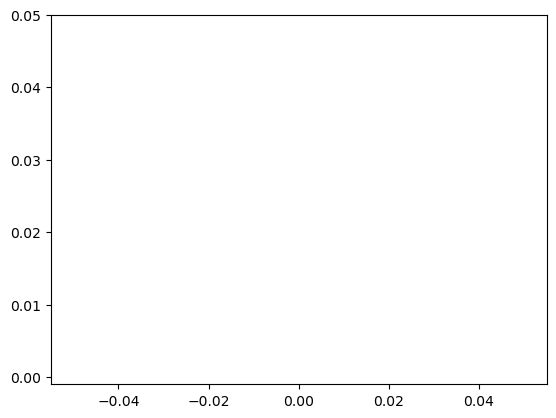

In [25]:
plt.plot(all_units_exp_var[:,1,13])
plt.ylim([-0.001, 0.05])

In [292]:
curr_sess_neural['UnitStats'].keys()

<KeysViewHDF5 ['FRate', 'Trial', 'Unit', 'stats']>